In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format
plt.style.use('seaborn-white')
# colorblind safe
plt.style.use('seaborn-colorblind')
plt.style.use('tableau-colorblind10')

# width and precision for f strings
width = 10
precision = 4

# default sizes for plots
# https://matplotlib.org/3.3.0/tutorials/introductory/customizing.html#customizing-with-matplotlibrc-files
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['font.size'] = 16
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['figure.titlesize'] = 'medium'
plt.rcParams['lines.linewidth'] = 2

# other settings
pd.options.display.float_format = '{:,.4f}'.format
pd.set_option("display.precision", 3)
np.set_printoptions(precision=3, suppress=True)
%load_ext autoreload
%autoreload 2
pd.set_option('display.max_columns', None)
%config IPCompleter.greedy=True


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
G_MAPS_API = os.environ.get("GOOGLE_STATICMAPS_API")

In [3]:
import random, time

In [4]:
import googlemaps

In [5]:
gmaps = googlemaps.Client(G_MAPS_API)

In [6]:
n_requests = 0

In [32]:
def download_images(client, df, zoomlevel, max_requests=10, prefix="", out_path="data/"):
    if not os.path.exists(out_path):
        os.makedirs(out_path)
    
    global n_requests
    
    for i, site in df.iterrows():
        print(f'Pulling image {i}, total API requests so far = {n_requests}')
        #print(f"{site['Latitude']}, {site['Longitude']}")
        
        # temp save coords
        lat = site['Latitude']
        long = site['Longitude']
        
        # and tags for site
        cat = site['Category']
        
        # create filename
        cur_filename = f'satimg_{prefix}_{i}_{cat}_{zoomlevel}_{lat}_{long}.png'
        print(cur_filename)

        # if it already exists, skip to next
        if os.path.exists(out_path + cur_filename):
            continue

        # get the image
        satimg = client.static_map(size = (400, 400), # pixels
           zoom = zoomlevel, # 1-21
           center = (lat, long),
           scale = 1, # default is 1, 2 returns 2x pixels for high res displays
           maptype = "satellite",
           format = "png"
          )
        
        # if it didn't work, exit
        if satimg is None or n_requests >= max_requests:
            print("API requests quota exceeded!")    
            break
        # increase counter otherwise
        n_requests += 1
        
        # save the current image
        f = open(out_path + cur_filename, 'wb')
        for chunk in satimg:
            if chunk:
                f.write(chunk)
        f.close()
        
        # open it to crop the text off
        img = plt.imread(out_path + cur_filename)
        # maybe crop all 4 sides?
        cropped = img[25:375, 25:375]
        # and resave
        #cropped_filename = f'satimg_{i}_{cat}_{zoomlevel}_{lat}_{long}.png'
        plt.imsave(out_path + cur_filename, cropped)
        
        # and rotate and save that version
        for k, degrees in enumerate([90, 180, 270]):
            #print(k, degrees)
            cropped_rotated = np.rot90(cropped, k=k)
            cropped_rot_filename = f'satimg_{prefix}_{i}_{cat}_{zoomlevel}_{lat}_{long}_rot{degrees}.png'
            #print(cropped_rot_filename)
            plt.imsave(out_path + cropped_rot_filename, cropped_rotated)
        
        # and zoom in and save
#         zoomed = img[100:300, 100:300]
#         zoomed_cropped_filename = f'satimg_{i}_{cat}_{zoomlevel}_zoomed_{lat}_{long}.png'
#         plt.imsave(out_path + zoomed_cropped_filename, zoomed)
        
#         # and rotate on zoom in and save
#         zoomed_rot = np.rot90(zoomed)
#         zoomed_cropped_rot_filename = f'satimg_{i}_{cat}_{zoomlevel}_zoomed_rot90_{lat}_{long}.png'
#         plt.imsave(out_path + zoomed_cropped_rot_filename, zoomed_rot)
        
        # wait a bit before next request
        wait_time = random.randint(1, 5)
        print(f'waiting for: {wait_time} seconds')
        time.sleep(wait_time) # in seconds

        # display samples every now and then
        if i % 100 == 0:
            img = plt.imread(out_path + cur_filename)
            plt.imshow(img)
            plt.title(f'image {i}')
            plt.show()
            time.sleep(2)
    return True

In [46]:
USdata_cleaned = pd.read_csv('../data/USdata_est_campgrounds_zip_states_combined_cleaned.csv')
USdata = pd.read_csv('../data/USdata_zip_states_combined_cleaned.csv')
to_combine = [USdata_cleaned, USdata]
USdata_with_est_campgrounds = pd.concat(to_combine)
# USdata_with_est_campgrounds.to_csv('data/USdata_est_campgrounds_zip_states_combined_cleaned.csv')

In [49]:
USdata_with_est_campgrounds.drop(['Unnamed: 0'], axis=1, inplace=True)

In [42]:
USdata_with_est_campgrounds = pd.read_csv('../data/USdata_est_campgrounds_zip_states_combined_cleaned.csv')
USdata_with_est_campgrounds.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)

KeyError: "['Unnamed: 0.1'] not found in axis"

In [43]:
categories = list(USdata_with_est_campgrounds['Category'].unique())
categories

['Established Campground']

In [50]:
cats = ['Established Campground', 'Wild Camping']
USdata_with_est_campgrounds = USdata_with_est_campgrounds[USdata_with_est_campgrounds['Category'].isin(cats)]

In [52]:
USdata_with_est_campgrounds['State'].unique()

array(['CA', 'UT', 'AK', 'OR', 'WA', 'WV', 'MD', 'MT', 'AZ', 'SE', 'NV',
       'CO', 'NM', 'TX', 'TN', 'KY', 'FL', 'ME', 'NC', 'VA', 'IL', 'SD',
       'NE', 'OH', 'WY', 'AR', 'MI', 'ID', 'MS', 'OK', 'GA', 'AL', 'LA',
       'SC', 'NY', 'VT', 'KS', 'MO', 'RV', 'US', 'NW', 'PA', 'WI', 'MA',
       'MN', 'NJ', 'SW', 'ND', 'IN', 'HI', 'IA', 'AB', 'NH', 'YT', 'DE',
       'CT', 'BC', 'RI', 'N.L.', 'NB', nan, 'QC', 'DC', 'ON', 'NS',
       'B.C.', 'Pue.'], dtype=object)

In [ ]:
names = ['TX', 'FL', 'AK', 'MT', 'NM', 'ID', 'WY', 'NV', 'NY']

In [10]:
USdata_with_est_campgrounds.groupby('State').agg('count')['Description'].sort_values(ascending=False).head(20)

State
CA    1698
AZ     886
OR     729
CO     707
WA     692
UT     651
TX     576
FL     465
AK     452
MT     446
NM     426
ID     383
WY     298
NV     285
NY     197
VA     161
NC     157
TN     152
MI     144
SD     144
Name: Description, dtype: int64

In [53]:
names = ['CA', 'AZ', 'CO', 'OR', 'UT', 'WA']

In [54]:
USdata_with_est_campgrounds = USdata_with_est_campgrounds[USdata_with_est_campgrounds['State'].isin(names)]

In [55]:
USdata_with_est_campgrounds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4058 entries, 0 to 8668
Data columns (total 38 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Location                   857 non-null    object 
 1   Name                       4058 non-null   object 
 2   Category                   4058 non-null   object 
 3   Description                4057 non-null   object 
 4   Latitude                   4058 non-null   float64
 5   Longitude                  4058 non-null   float64
 6   Altitude                   3994 non-null   float64
 7   Date verified              4058 non-null   object 
 8   Open                       4058 non-null   object 
 9   Electricity                4058 non-null   object 
 10  Wifi                       4058 non-null   object 
 11  Kitchen                    4058 non-null   object 
 12  Parking                    0 non-null      float64
 13  Restaurant                 4058 non-null   objec

Wild Camping
Pulling image 0, total API requests so far = 0
satimg_CO__0_Wild Camping_17_37.238067_-107.524203.png
waiting for: 3 seconds


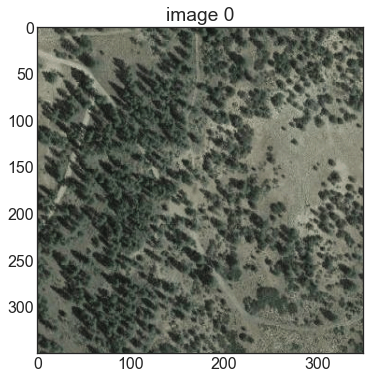

Pulling image 1, total API requests so far = 1
satimg_CO__1_Wild Camping_17_37.812975_-107.905482.png
waiting for: 5 seconds
Pulling image 4, total API requests so far = 2
satimg_CO__4_Wild Camping_17_39.39521_-108.106147.png
waiting for: 2 seconds
Pulling image 5, total API requests so far = 3
satimg_CO__5_Wild Camping_17_38.838421_-107.517971.png
waiting for: 3 seconds
Pulling image 9, total API requests so far = 4
satimg_CO__9_Wild Camping_17_39.307964_-108.702567.png
waiting for: 1 seconds
Pulling image 10, total API requests so far = 5
satimg_CO__10_Wild Camping_17_39.092332_-108.808072.png
waiting for: 4 seconds
Pulling image 11, total API requests so far = 6
satimg_CO__11_Wild Camping_17_38.776797_-108.288448.png
waiting for: 5 seconds
Pulling image 13, total API requests so far = 7
satimg_CO__13_Wild Camping_17_39.368473_-106.786083.png
waiting for: 2 seconds
Pulling image 14, total API requests so far = 8
satimg_CO__14_Wild Camping_17_40.244703_-104.05243.png
waiting for: 4 se

waiting for: 4 seconds
Pulling image 86, total API requests so far = 66
satimg_CO__86_Wild Camping_17_39.8346_-106.05345.png
waiting for: 2 seconds
Pulling image 87, total API requests so far = 67
satimg_CO__87_Wild Camping_17_39.01828_-105.18099.png
waiting for: 2 seconds
Pulling image 90, total API requests so far = 68
satimg_CO__90_Wild Camping_17_39.772194_-105.762246.png
waiting for: 5 seconds
Pulling image 93, total API requests so far = 69
satimg_CO__93_Wild Camping_17_39.100859_-106.368014.png
waiting for: 2 seconds
Pulling image 94, total API requests so far = 70
satimg_CO__94_Wild Camping_17_39.151353_-106.425406.png
waiting for: 3 seconds
Pulling image 95, total API requests so far = 71
satimg_CO__95_Wild Camping_17_40.165868_-105.457831.png
waiting for: 4 seconds
Pulling image 96, total API requests so far = 72
satimg_CO__96_Wild Camping_17_40.139004_-106.105506.png
waiting for: 4 seconds
Pulling image 97, total API requests so far = 73
satimg_CO__97_Wild Camping_17_39.2467

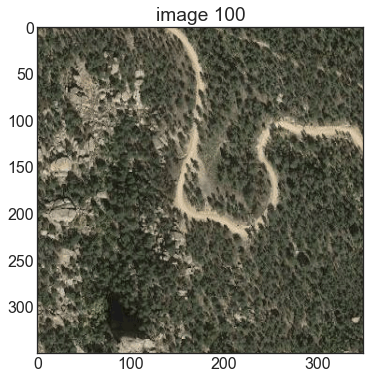

Pulling image 105, total API requests so far = 77
satimg_CO__105_Wild Camping_17_38.06261_-107.66027.png
waiting for: 3 seconds
Pulling image 106, total API requests so far = 78
satimg_CO__106_Wild Camping_17_38.53206_-102.52848.png
waiting for: 2 seconds
Pulling image 108, total API requests so far = 79
satimg_CO__108_Wild Camping_17_37.75222_-107.97693999999998.png
waiting for: 2 seconds
Pulling image 109, total API requests so far = 80
satimg_CO__109_Wild Camping_17_37.66889000000001_-108.32528.png
waiting for: 3 seconds
Pulling image 110, total API requests so far = 81
satimg_CO__110_Wild Camping_17_38.04722_-107.80917.png
waiting for: 2 seconds
Pulling image 111, total API requests so far = 82
satimg_CO__111_Wild Camping_17_38.92778_-107.27472.png
waiting for: 1 seconds
Pulling image 112, total API requests so far = 83
satimg_CO__112_Wild Camping_17_38.972505_-103.460771.png
waiting for: 5 seconds
Pulling image 113, total API requests so far = 84
satimg_CO__113_Wild Camping_17_37.

waiting for: 4 seconds
Pulling image 198, total API requests so far = 140
satimg_CO__198_Wild Camping_17_39.57495_-106.110771.png
waiting for: 2 seconds
Pulling image 199, total API requests so far = 141
satimg_CO__199_Wild Camping_17_37.720631_-107.749573.png
waiting for: 3 seconds
Pulling image 200, total API requests so far = 142
satimg_CO__200_Wild Camping_17_38.943307_-106.186081.png
waiting for: 5 seconds


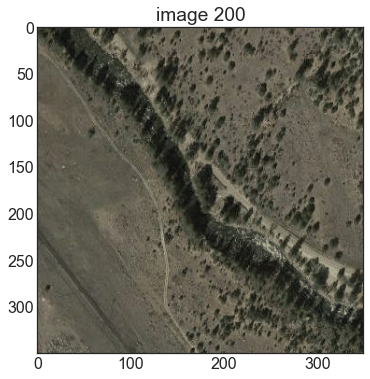

Pulling image 201, total API requests so far = 143
satimg_CO__201_Wild Camping_17_39.41959600000001_-106.272577.png
waiting for: 2 seconds
Pulling image 202, total API requests so far = 144
satimg_CO__202_Wild Camping_17_39.622652_-106.907416.png
waiting for: 2 seconds
Pulling image 205, total API requests so far = 145
satimg_CO__205_Wild Camping_17_40.124126_-105.532433.png
waiting for: 5 seconds
Pulling image 206, total API requests so far = 146
satimg_CO__206_Wild Camping_17_39.350404_-106.585145.png
waiting for: 2 seconds
Pulling image 208, total API requests so far = 147
satimg_CO__208_Wild Camping_17_39.513834_-106.428997.png
waiting for: 1 seconds
Pulling image 211, total API requests so far = 148
satimg_CO__211_Wild Camping_17_39.32121_-105.251605.png
waiting for: 4 seconds
Pulling image 212, total API requests so far = 149
satimg_CO__212_Wild Camping_17_37.394388_-108.06817.png
waiting for: 3 seconds
Pulling image 213, total API requests so far = 150
satimg_CO__213_Wild Campin

waiting for: 3 seconds
Pulling image 282, total API requests so far = 206
satimg_CO__282_Wild Camping_17_38.49635900000001_-105.028626.png
waiting for: 5 seconds
Pulling image 283, total API requests so far = 207
satimg_CO__283_Wild Camping_17_39.822497_-108.828981.png
waiting for: 3 seconds
Pulling image 284, total API requests so far = 208
satimg_CO__284_Wild Camping_17_37.800821_-107.577759.png
waiting for: 4 seconds
Pulling image 286, total API requests so far = 209
satimg_CO__286_Wild Camping_17_40.051488_-105.735293.png
waiting for: 5 seconds
Pulling image 289, total API requests so far = 210
satimg_CO__289_Wild Camping_17_37.4998_-106.763231.png
waiting for: 5 seconds
Pulling image 291, total API requests so far = 211
satimg_CO__291_Wild Camping_17_39.566972_-107.317933.png
waiting for: 4 seconds
Pulling image 293, total API requests so far = 212
satimg_CO__293_Wild Camping_17_39.24003_-106.23385.png
waiting for: 4 seconds
Pulling image 296, total API requests so far = 213
satim

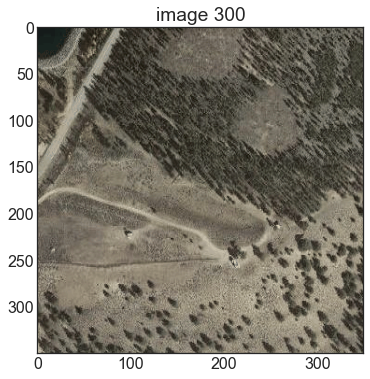

Pulling image 301, total API requests so far = 218
satimg_CO__301_Wild Camping_17_39.106134_-106.383417.png
waiting for: 4 seconds
Pulling image 304, total API requests so far = 219
satimg_CO__304_Wild Camping_17_37.59268400000001_-108.940319.png
waiting for: 2 seconds
Pulling image 305, total API requests so far = 220
satimg_CO__305_Wild Camping_17_38.375386_-108.733312.png
waiting for: 5 seconds
Pulling image 307, total API requests so far = 221
satimg_CO__307_Wild Camping_17_40.525327_-104.996499.png
waiting for: 3 seconds
Pulling image 308, total API requests so far = 222
satimg_CO__308_Wild Camping_17_39.43395_-106.05963.png
waiting for: 5 seconds
Pulling image 311, total API requests so far = 223
satimg_CO__311_Wild Camping_17_39.120114_-105.451712.png
waiting for: 2 seconds
Pulling image 317, total API requests so far = 224
satimg_CO__317_Wild Camping_17_39.672669_-104.982995.png
waiting for: 2 seconds
Pulling image 320, total API requests so far = 225
satimg_CO__320_Wild Campin

waiting for: 5 seconds
Pulling image 400, total API requests so far = 281
satimg_CO__400_Wild Camping_17_37.367449_-107.894099.png
waiting for: 4 seconds


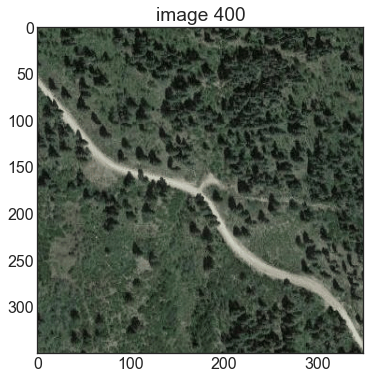

Pulling image 401, total API requests so far = 282
satimg_CO__401_Wild Camping_17_37.908767_-107.600666.png
waiting for: 4 seconds
Pulling image 402, total API requests so far = 283
satimg_CO__402_Wild Camping_17_37.25113_-105.129078.png
waiting for: 2 seconds
Pulling image 403, total API requests so far = 284
satimg_CO__403_Wild Camping_17_40.384146_-106.623231.png
waiting for: 5 seconds
Pulling image 404, total API requests so far = 285
satimg_CO__404_Wild Camping_17_40.873977_-106.220514.png
waiting for: 4 seconds
Pulling image 405, total API requests so far = 286
satimg_CO__405_Wild Camping_17_39.544466_-106.139692.png
waiting for: 3 seconds
Pulling image 406, total API requests so far = 287
satimg_CO__406_Wild Camping_17_39.520037_-106.146201.png
waiting for: 3 seconds
Pulling image 407, total API requests so far = 288
satimg_CO__407_Wild Camping_17_38.744911_-106.20488600000002.png
waiting for: 4 seconds
Pulling image 408, total API requests so far = 289
satimg_CO__408_Wild Campi

waiting for: 2 seconds
Pulling image 481, total API requests so far = 345
satimg_CO__481_Wild Camping_17_37.654373_-107.801874.png
waiting for: 1 seconds
Pulling image 482, total API requests so far = 346
satimg_CO__482_Wild Camping_17_37.36806_-108.17618.png
waiting for: 4 seconds
Pulling image 483, total API requests so far = 347
satimg_CO__483_Wild Camping_17_37.397024_-108.821426.png
waiting for: 4 seconds
Pulling image 484, total API requests so far = 348
satimg_CO__484_Wild Camping_17_37.8655_-105.41042.png
waiting for: 1 seconds
Pulling image 485, total API requests so far = 349
satimg_CO__485_Wild Camping_17_40.56707_-105.36362.png
waiting for: 1 seconds
Pulling image 486, total API requests so far = 350
satimg_CO__486_Wild Camping_17_39.06547_-108.751857.png
waiting for: 3 seconds
Pulling image 488, total API requests so far = 351
satimg_CO__488_Wild Camping_17_37.821788_-107.720018.png
waiting for: 5 seconds
Pulling image 489, total API requests so far = 352
satimg_CO__489_Wi

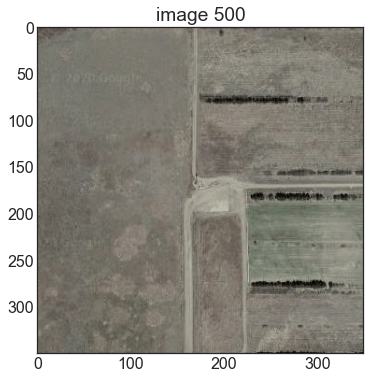

Pulling image 503, total API requests so far = 361
satimg_CO__503_Wild Camping_17_37.102043_-105.384856.png
waiting for: 4 seconds
Pulling image 505, total API requests so far = 362
satimg_CO__505_Wild Camping_17_38.064366_-107.667477.png
waiting for: 5 seconds
Pulling image 506, total API requests so far = 363
satimg_CO__506_Wild Camping_17_39.399604_-108.812415.png
waiting for: 1 seconds
Pulling image 507, total API requests so far = 364
satimg_CO__507_Wild Camping_17_37.37492_-106.965934.png
waiting for: 1 seconds
Pulling image 508, total API requests so far = 365
satimg_CO__508_Wild Camping_17_38.767902_-106.765822.png
waiting for: 2 seconds
Pulling image 509, total API requests so far = 366
satimg_CO__509_Wild Camping_17_38.17458_-105.15155.png
waiting for: 5 seconds
Pulling image 510, total API requests so far = 367
satimg_CO__510_Wild Camping_17_39.439804_-106.397395.png
waiting for: 5 seconds
Pulling image 512, total API requests so far = 368
satimg_CO__512_Wild Camping_17_38.8

waiting for: 3 seconds
Pulling image 138, total API requests so far = 423
satimg_CO__138_Informal Campsite_17_39.582525_-105.360861.png
waiting for: 2 seconds
Pulling image 139, total API requests so far = 424
satimg_CO__139_Informal Campsite_17_38.49984_-106.23237.png
waiting for: 2 seconds
Pulling image 144, total API requests so far = 425
satimg_CO__144_Informal Campsite_17_39.695973_-104.832612.png
waiting for: 3 seconds
Pulling image 148, total API requests so far = 426
satimg_CO__148_Informal Campsite_17_39.737853_-104.527413.png
waiting for: 1 seconds
Pulling image 157, total API requests so far = 427
satimg_CO__157_Informal Campsite_17_39.59194_-104.861127.png
waiting for: 3 seconds
Pulling image 158, total API requests so far = 428
satimg_CO__158_Informal Campsite_17_39.179792_-109.021499.png
waiting for: 1 seconds
Pulling image 161, total API requests so far = 429
satimg_CO__161_Informal Campsite_17_37.954387_-107.828845.png
waiting for: 4 seconds
Pulling image 166, total API

waiting for: 5 seconds
Pulling image 490, total API requests so far = 484
satimg_CO__490_Informal Campsite_17_38.524514_-106.021702.png
waiting for: 2 seconds
Pulling image 494, total API requests so far = 485
satimg_CO__494_Informal Campsite_17_37.998948_-103.593968.png
waiting for: 3 seconds
Pulling image 499, total API requests so far = 486
satimg_CO__499_Informal Campsite_17_38.50578_-106.951536.png
waiting for: 3 seconds
Pulling image 501, total API requests so far = 487
satimg_CO__501_Informal Campsite_17_38.093897_-103.054223.png
waiting for: 4 seconds
Pulling image 502, total API requests so far = 488
satimg_CO__502_Informal Campsite_17_37.26902000000001_-106.99716.png
waiting for: 2 seconds
Pulling image 504, total API requests so far = 489
satimg_CO__504_Informal Campsite_17_37.361218_-108.07808.png
waiting for: 2 seconds
Pulling image 511, total API requests so far = 490
satimg_CO__511_Informal Campsite_17_37.169603_-105.517145.png
waiting for: 1 seconds
Pulling image 513, t

waiting for: 5 seconds
Pulling image 383, total API requests so far = 548
satimg_CO__383_Eco-Friendly_17_38.82507_-106.13977.png
waiting for: 2 seconds
Pulling image 395, total API requests so far = 549
satimg_CO__395_Eco-Friendly_17_39.387498_-107.083325.png
waiting for: 4 seconds


In [25]:
# for category in categories:
#     print(category)
#     tempdf = USdata_CO[USdata_CO['Category'] == category]
#     #tempdf.info()
#     download_images(gmaps, tempdf, max_requests=max_requests, zoomlevel=17, prefix="CO", out_path=f"data/sites_CO/{category}/")

In [28]:
categories = categories[1:]

In [19]:
# we didn't get the other categories because we used the wrong file, so get everything now except Est Campgrounds
USdata_with_est_campgrounds = USdata_with_est_campgrounds[USdata_with_est_campgrounds['Category'] != 'Established Campground']

In [20]:
# USdata_CA = USdata_cleaned[USdata_cleaned['State'] == 'CA'].copy()
# USdata_AZ = USdata_cleaned[USdata_cleaned['State'] == 'AZ'].copy()
# USdata_OR = USdata_cleaned[USdata_cleaned['State'] == 'OR'].copy()
# USdata_UT = USdata_cleaned[USdata_cleaned['State'] == 'UT'].copy()
# USdata_WA = USdata_cleaned[USdata_cleaned['State'] == 'WA'].copy()


USdata_TX = USdata_with_est_campgrounds[USdata_with_est_campgrounds['State'] == 'TX'].copy()
USdata_FL = USdata_with_est_campgrounds[USdata_with_est_campgrounds['State'] == 'FL'].copy()
USdata_AK = USdata_with_est_campgrounds[USdata_with_est_campgrounds['State'] == 'AK'].copy()
USdata_MT = USdata_with_est_campgrounds[USdata_with_est_campgrounds['State'] == 'MT'].copy()
USdata_NM = USdata_with_est_campgrounds[USdata_with_est_campgrounds['State'] == 'NM'].copy()
USdata_ID = USdata_with_est_campgrounds[USdata_with_est_campgrounds['State'] == 'ID'].copy()
USdata_WY = USdata_with_est_campgrounds[USdata_with_est_campgrounds['State'] == 'WY'].copy()
USdata_NV = USdata_with_est_campgrounds[USdata_with_est_campgrounds['State'] == 'NV'].copy()
USdata_NY = USdata_with_est_campgrounds[USdata_with_est_campgrounds['State'] == 'NY'].copy()
# maybe TX, AK, NM

In [24]:
state_dfs = [USdata_TX,  
            USdata_FL,
            USdata_AK,
            USdata_MT,
            USdata_NM,
            USdata_ID,
            USdata_WY, 
            USdata_NV,
            USdata_NY]

In [25]:
max_requests = 10_000

Wild Camping
TX
Pulling image 3794, total API requests so far = 8
satimg_TX_3794_Wild Camping_17_33.776876_-96.155686.png
waiting for: 5 seconds
Pulling image 3927, total API requests so far = 9
satimg_TX_3927_Wild Camping_17_31.923249_-106.573051.png
waiting for: 5 seconds
Pulling image 3941, total API requests so far = 10
satimg_TX_3941_Wild Camping_17_31.802540000000004_-100.943841.png
waiting for: 1 seconds
Pulling image 3954, total API requests so far = 11
satimg_TX_3954_Wild Camping_17_30.339916_-97.686755.png
waiting for: 5 seconds
Pulling image 3961, total API requests so far = 12
satimg_TX_3961_Wild Camping_17_29.365284999999997_-94.77958100000001.png
waiting for: 4 seconds
Pulling image 4277, total API requests so far = 13
satimg_TX_4277_Wild Camping_17_27.485357_-97.270055.png
waiting for: 4 seconds
Pulling image 4347, total API requests so far = 14
satimg_TX_4347_Wild Camping_17_30.244159000000003_-97.80019.png
waiting for: 5 seconds
Pulling image 4391, total API requests s

waiting for: 4 seconds
Pulling image 9151, total API requests so far = 69
satimg_TX_9151_Wild Camping_17_30.312201_-104.011326.png
waiting for: 3 seconds
Pulling image 9156, total API requests so far = 70
satimg_TX_9156_Wild Camping_17_31.878258000000002_-104.823275.png
waiting for: 1 seconds
Pulling image 9194, total API requests so far = 71
satimg_TX_9194_Wild Camping_17_30.656259999999996_-97.41441.png
waiting for: 3 seconds
Pulling image 9225, total API requests so far = 72
satimg_TX_9225_Wild Camping_17_33.089279_-95.013362.png
waiting for: 4 seconds
Pulling image 9283, total API requests so far = 73
satimg_TX_9283_Wild Camping_17_26.90145_-99.2671.png
waiting for: 1 seconds
Pulling image 9284, total API requests so far = 74
satimg_TX_9284_Wild Camping_17_26.90222_-99.26754.png
waiting for: 5 seconds
Pulling image 9382, total API requests so far = 75
satimg_TX_9382_Wild Camping_17_32.929221999999996_-96.471797.png
waiting for: 2 seconds
Pulling image 9391, total API requests so fa

waiting for: 4 seconds
Pulling image 4234, total API requests so far = 129
satimg_TX_4234_Informal Campsite_17_31.768582000000002_-106.30041399999999.png
waiting for: 3 seconds
Pulling image 4299, total API requests so far = 130
satimg_TX_4299_Informal Campsite_17_29.432264_-97.17305400000001.png
waiting for: 4 seconds
Pulling image 4317, total API requests so far = 131
satimg_TX_4317_Informal Campsite_17_32.358273_-94.465.png
waiting for: 4 seconds
Pulling image 4396, total API requests so far = 132
satimg_TX_4396_Informal Campsite_17_32.792829_-97.346448.png
waiting for: 4 seconds
Pulling image 4431, total API requests so far = 133
satimg_TX_4431_Informal Campsite_17_33.12147_-96.662849.png
waiting for: 1 seconds
Pulling image 4531, total API requests so far = 134
satimg_TX_4531_Informal Campsite_17_29.406078000000004_-103.09089499999999.png
waiting for: 2 seconds
Pulling image 4537, total API requests so far = 135
satimg_TX_4537_Informal Campsite_17_27.551933000000002_-99.505266.png

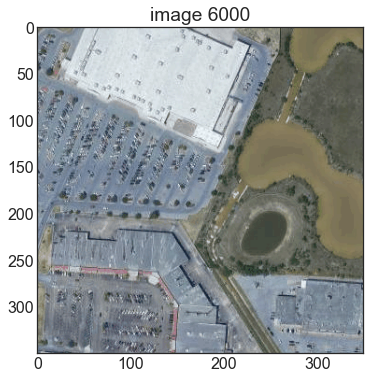

Pulling image 6006, total API requests so far = 162
satimg_TX_6006_Informal Campsite_17_29.383823_-94.722277.png
waiting for: 3 seconds
Pulling image 6008, total API requests so far = 163
satimg_TX_6008_Informal Campsite_17_31.828120000000002_-106.44628.png
waiting for: 1 seconds
Pulling image 6048, total API requests so far = 164
satimg_TX_6048_Informal Campsite_17_32.31767_-102.55483000000001.png
waiting for: 2 seconds
Pulling image 6069, total API requests so far = 165
satimg_TX_6069_Informal Campsite_17_32.039783_-102.07141700000001.png
waiting for: 2 seconds
Pulling image 6092, total API requests so far = 166
satimg_TX_6092_Informal Campsite_17_30.11338_-97.350825.png
waiting for: 2 seconds
Pulling image 6095, total API requests so far = 167
satimg_TX_6095_Informal Campsite_17_26.56901_-97.42929000000001.png
waiting for: 3 seconds
Pulling image 6112, total API requests so far = 168
satimg_TX_6112_Informal Campsite_17_32.732416_-97.795626.png
waiting for: 5 seconds
Pulling image 61

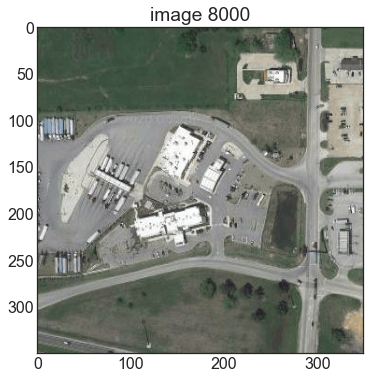

Pulling image 8259, total API requests so far = 199
satimg_TX_8259_Informal Campsite_17_32.92281_-96.839394.png
waiting for: 4 seconds
Pulling image 8469, total API requests so far = 200
satimg_TX_8469_Informal Campsite_17_32.460675_-99.872642.png
waiting for: 4 seconds
Pulling image 8517, total API requests so far = 201
satimg_TX_8517_Informal Campsite_17_32.591282_-96.880556.png
waiting for: 4 seconds
Pulling image 8564, total API requests so far = 202
satimg_TX_8564_Informal Campsite_17_32.908217_-96.449939.png
waiting for: 1 seconds
Pulling image 8704, total API requests so far = 203
satimg_TX_8704_Informal Campsite_17_31.30196500000001_-105.84110700000001.png
waiting for: 5 seconds
Pulling image 8713, total API requests so far = 204
satimg_TX_8713_Informal Campsite_17_30.121443_-94.167659.png
waiting for: 1 seconds
Pulling image 8731, total API requests so far = 205
satimg_TX_8731_Informal Campsite_17_32.409966_-99.78045300000001.png
waiting for: 1 seconds
Pulling image 8732, tota

Pulling image 9535, total API requests so far = 257
satimg_TX_9535_Informal Campsite_17_30.667391_-96.822197.png
waiting for: 5 seconds
Pulling image 9561, total API requests so far = 258
satimg_TX_9561_Informal Campsite_17_30.367495_-103.63601899999999.png
waiting for: 4 seconds
Pulling image 9571, total API requests so far = 259
satimg_TX_9571_Informal Campsite_17_31.603519_-97.108774.png
waiting for: 4 seconds
Pulling image 9577, total API requests so far = 260
satimg_TX_9577_Informal Campsite_17_26.19259_-97.721999.png
waiting for: 3 seconds
Pulling image 9599, total API requests so far = 261
satimg_TX_9599_Informal Campsite_17_29.328322999999997_-96.12286999999999.png
waiting for: 1 seconds
Pulling image 9650, total API requests so far = 262
satimg_TX_9650_Informal Campsite_17_29.8269_-99.5338.png
waiting for: 5 seconds
Pulling image 9687, total API requests so far = 263
satimg_TX_9687_Informal Campsite_17_32.296369_-95.26133100000001.png
waiting for: 3 seconds
Pulling image 9742,

waiting for: 2 seconds
Water
TX
Pulling image 5659, total API requests so far = 315
satimg_TX_5659_Water_17_30.309748_-104.019932.png
waiting for: 4 seconds
Pulling image 6079, total API requests so far = 316
satimg_TX_6079_Water_17_34.237827_-102.745897.png
waiting for: 1 seconds
Pulling image 6230, total API requests so far = 317
satimg_TX_6230_Water_17_31.757146000000002_-106.272884.png
waiting for: 4 seconds
Pulling image 6271, total API requests so far = 318
satimg_TX_6271_Water_17_28.752340999999998_-100.496623.png
waiting for: 4 seconds
Pulling image 6333, total API requests so far = 319
satimg_TX_6333_Water_17_30.255605_-97.739838.png
waiting for: 2 seconds
Pulling image 6887, total API requests so far = 320
satimg_TX_6887_Water_17_29.46722_-94.611684.png
waiting for: 3 seconds
Pulling image 8856, total API requests so far = 321
satimg_TX_8856_Water_17_30.208470000000002_-103.26463000000001.png
waiting for: 5 seconds
Pulling image 9075, total API requests so far = 322
satimg_TX

waiting for: 4 seconds
Pulling image 6200, total API requests so far = 376
satimg_FL_6200_Wild Camping_17_26.399905_-81.869486.png
waiting for: 3 seconds


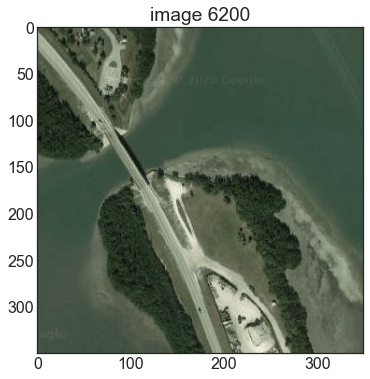

Pulling image 6207, total API requests so far = 377
satimg_FL_6207_Wild Camping_17_25.994183_-81.301574.png
waiting for: 2 seconds
Pulling image 6218, total API requests so far = 378
satimg_FL_6218_Wild Camping_17_28.375026000000002_-80.80274.png
waiting for: 4 seconds
Pulling image 6265, total API requests so far = 379
satimg_FL_6265_Wild Camping_17_29.037074_-81.537847.png
waiting for: 2 seconds
Pulling image 6291, total API requests so far = 380
satimg_FL_6291_Wild Camping_17_30.77495_-85.82633.png
waiting for: 5 seconds
Pulling image 6316, total API requests so far = 381
satimg_FL_6316_Wild Camping_17_27.582604999999997_-81.510301.png
waiting for: 4 seconds
Pulling image 6367, total API requests so far = 382
satimg_FL_6367_Wild Camping_17_26.933697_-81.31647.png
waiting for: 5 seconds
Pulling image 6419, total API requests so far = 383
satimg_FL_6419_Wild Camping_17_29.77239_-83.57977.png
waiting for: 3 seconds
Pulling image 6467, total API requests so far = 384
satimg_FL_6467_Wild

waiting for: 1 seconds
Pulling image 12346, total API requests so far = 438
satimg_FL_12346_Wild Camping_17_29.01111_-81.54278000000002.png
waiting for: 4 seconds
Pulling image 12347, total API requests so far = 439
satimg_FL_12347_Wild Camping_17_29.0325_-80.91417.png
waiting for: 5 seconds
Pulling image 12348, total API requests so far = 440
satimg_FL_12348_Wild Camping_17_27.760279999999998_-80.41778000000002.png
waiting for: 1 seconds
Pulling image 12349, total API requests so far = 441
satimg_FL_12349_Wild Camping_17_29.91222_-84.61721999999997.png
waiting for: 4 seconds
Pulling image 12350, total API requests so far = 442
satimg_FL_12350_Wild Camping_17_30.656940000000002_-85.90666999999998.png
waiting for: 2 seconds
Pulling image 12351, total API requests so far = 443
satimg_FL_12351_Wild Camping_17_30.324170000000002_-86.09333000000002.png
waiting for: 4 seconds
Informal Campsite
FL
Pulling image 3787, total API requests so far = 444
satimg_FL_3787_Informal Campsite_17_28.9625_

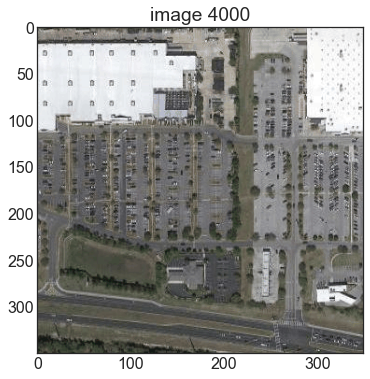

Pulling image 4006, total API requests so far = 448
satimg_FL_4006_Informal Campsite_17_29.596261_-83.38978399999998.png
waiting for: 1 seconds
Pulling image 4007, total API requests so far = 449
satimg_FL_4007_Informal Campsite_17_28.21157100000001_-82.741199.png
waiting for: 5 seconds
Pulling image 4060, total API requests so far = 450
satimg_FL_4060_Informal Campsite_17_25.86419_-80.1215.png
waiting for: 1 seconds
Pulling image 4086, total API requests so far = 451
satimg_FL_4086_Informal Campsite_17_27.450706_-82.690933.png
waiting for: 4 seconds
Pulling image 4088, total API requests so far = 452
satimg_FL_4088_Informal Campsite_17_30.630581_-87.02992900000002.png
waiting for: 3 seconds
Pulling image 4097, total API requests so far = 453
satimg_FL_4097_Informal Campsite_17_30.727415_-86.566402.png
waiting for: 4 seconds
Pulling image 4110, total API requests so far = 454
satimg_FL_4110_Informal Campsite_17_30.288518_-81.419493.png
waiting for: 4 seconds
Pulling image 4112, total A

waiting for: 2 seconds
Pulling image 6223, total API requests so far = 507
satimg_FL_6223_Informal Campsite_17_28.552582_-80.853171.png
waiting for: 4 seconds
Pulling image 6229, total API requests so far = 508
satimg_FL_6229_Informal Campsite_17_26.156935999999998_-81.684989.png
waiting for: 3 seconds
Pulling image 6405, total API requests so far = 509
satimg_FL_6405_Informal Campsite_17_27.207395_-81.830579.png
waiting for: 4 seconds
Pulling image 6412, total API requests so far = 510
satimg_FL_6412_Informal Campsite_17_27.568309999999997_-81.81458.png
waiting for: 1 seconds
Pulling image 6421, total API requests so far = 511
satimg_FL_6421_Informal Campsite_17_29.560121999999996_-82.945987.png
waiting for: 5 seconds
Pulling image 7290, total API requests so far = 512
satimg_FL_7290_Informal Campsite_17_30.091476_-81.497078.png
waiting for: 1 seconds
Pulling image 7955, total API requests so far = 513
satimg_FL_7955_Informal Campsite_17_27.601487_-80.822833.png
waiting for: 5 seconds

waiting for: 5 seconds
Pulling image 9314, total API requests so far = 566
satimg_FL_9314_Informal Campsite_17_27.461416999999997_-82.583896.png
waiting for: 5 seconds
Pulling image 9315, total API requests so far = 567
satimg_FL_9315_Informal Campsite_17_27.087099_-81.071859.png
waiting for: 1 seconds
Pulling image 9336, total API requests so far = 568
satimg_FL_9336_Informal Campsite_17_30.319879999999998_-82.973164.png
waiting for: 2 seconds
Pulling image 9342, total API requests so far = 569
satimg_FL_9342_Informal Campsite_17_27.072013000000002_-82.448466.png
waiting for: 2 seconds
Pulling image 9454, total API requests so far = 570
satimg_FL_9454_Informal Campsite_17_28.684719_-81.50966600000002.png
waiting for: 1 seconds
Pulling image 9459, total API requests so far = 571
satimg_FL_9459_Informal Campsite_17_29.89047_-81.31054.png
waiting for: 5 seconds
Pulling image 9493, total API requests so far = 572
satimg_FL_9493_Informal Campsite_17_28.290494_-81.406917.png
waiting for: 5 

Pulling image 4451, total API requests so far = 627
satimg_AK_4451_Wild Camping_17_60.777767000000004_-149.2276.png
waiting for: 3 seconds
Pulling image 4499, total API requests so far = 628
satimg_AK_4499_Wild Camping_17_63.804314_-148.946451.png
waiting for: 5 seconds
Pulling image 4556, total API requests so far = 629
satimg_AK_4556_Wild Camping_17_61.82880600000001_-147.338165.png
waiting for: 3 seconds
Pulling image 4558, total API requests so far = 630
satimg_AK_4558_Wild Camping_17_63.320138_-142.727618.png
waiting for: 1 seconds
Pulling image 4567, total API requests so far = 631
satimg_AK_4567_Wild Camping_17_63.787778_-144.792224.png
waiting for: 1 seconds
Pulling image 4588, total API requests so far = 632
satimg_AK_4588_Wild Camping_17_61.85005200000001_-147.383225.png
waiting for: 5 seconds
Pulling image 4596, total API requests so far = 633
satimg_AK_4596_Wild Camping_17_65.352666_-148.26693500000005.png
waiting for: 1 seconds
Pulling image 4641, total API requests so far

waiting for: 5 seconds
Pulling image 7295, total API requests so far = 687
satimg_AK_7295_Wild Camping_17_63.462132999999994_-148.80596599999996.png
waiting for: 1 seconds
Pulling image 7300, total API requests so far = 688
satimg_AK_7300_Wild Camping_17_62.88821_-141.54304.png
waiting for: 4 seconds


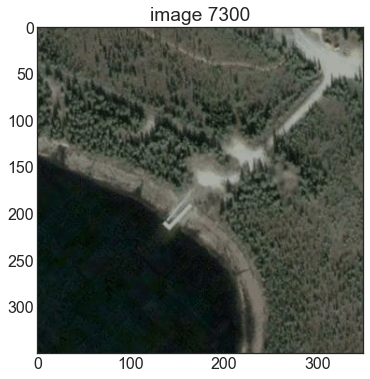

Pulling image 7334, total API requests so far = 689
satimg_AK_7334_Wild Camping_17_60.82083000000001_-149.5425.png
waiting for: 4 seconds
Pulling image 7335, total API requests so far = 690
satimg_AK_7335_Wild Camping_17_61.10917_-146.25778.png
waiting for: 1 seconds
Pulling image 7336, total API requests so far = 691
satimg_AK_7336_Wild Camping_17_62.62319_-143.71319.png
waiting for: 1 seconds
Pulling image 7374, total API requests so far = 692
satimg_AK_7374_Wild Camping_17_60.919824_-149.49223600000005.png
waiting for: 5 seconds
Pulling image 7399, total API requests so far = 693
satimg_AK_7399_Wild Camping_17_62.323179_-150.112652.png
waiting for: 4 seconds
Pulling image 7403, total API requests so far = 694
satimg_AK_7403_Wild Camping_17_62.616155000000006_-143.684619.png
waiting for: 4 seconds
Pulling image 7409, total API requests so far = 695
satimg_AK_7409_Wild Camping_17_62.104075_-150.048914.png
waiting for: 3 seconds
Pulling image 7410, total API requests so far = 696
satim

waiting for: 2 seconds
Pulling image 11169, total API requests so far = 750
satimg_AK_11169_Wild Camping_17_63.105738_-146.65536799999995.png
waiting for: 3 seconds
Pulling image 11170, total API requests so far = 751
satimg_AK_11170_Wild Camping_17_61.608582_-149.06923700000004.png
waiting for: 4 seconds
Pulling image 11173, total API requests so far = 752
satimg_AK_11173_Wild Camping_17_70.19710699999999_-148.407535.png
waiting for: 1 seconds
Pulling image 11181, total API requests so far = 753
satimg_AK_11181_Wild Camping_17_64.064872_-141.995996.png
waiting for: 4 seconds
Pulling image 11342, total API requests so far = 754
satimg_AK_11342_Wild Camping_17_63.703131000000006_-144.637214.png
waiting for: 1 seconds
Pulling image 11343, total API requests so far = 755
satimg_AK_11343_Wild Camping_17_64.08346800000001_-141.604716.png
waiting for: 1 seconds
Pulling image 11347, total API requests so far = 756
satimg_AK_11347_Wild Camping_17_64.28766_-146.45793999999995.png
waiting for: 1

waiting for: 1 seconds
Pulling image 11951, total API requests so far = 809
satimg_AK_11951_Wild Camping_17_61.489208999999995_-144.015368.png
waiting for: 2 seconds
Pulling image 11956, total API requests so far = 810
satimg_AK_11956_Wild Camping_17_67.973342_-149.769915.png
waiting for: 2 seconds
Pulling image 12001, total API requests so far = 811
satimg_AK_12001_Wild Camping_17_61.125525_-145.726402.png
waiting for: 1 seconds
Pulling image 12010, total API requests so far = 812
satimg_AK_12010_Wild Camping_17_63.383839_-148.917378.png
waiting for: 4 seconds
Pulling image 12011, total API requests so far = 813
satimg_AK_12011_Wild Camping_17_64.858195_-147.818592.png
waiting for: 1 seconds
Pulling image 12012, total API requests so far = 814
satimg_AK_12012_Wild Camping_17_64.953835_-148.363323.png
waiting for: 2 seconds
Pulling image 12013, total API requests so far = 815
satimg_AK_12013_Wild Camping_17_64.946448_-148.44159299999995.png
waiting for: 5 seconds
Pulling image 12014, t

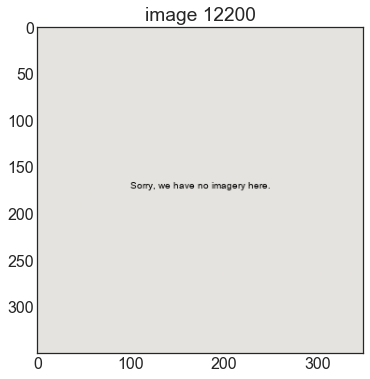

Pulling image 12202, total API requests so far = 837
satimg_AK_12202_Wild Camping_17_63.912351_-149.079035.png
waiting for: 1 seconds
Pulling image 12206, total API requests so far = 838
satimg_AK_12206_Wild Camping_17_63.228669_-145.481523.png
waiting for: 1 seconds
Pulling image 12225, total API requests so far = 839
satimg_AK_12225_Wild Camping_17_64.050324_-145.742124.png
waiting for: 4 seconds
Pulling image 12269, total API requests so far = 840
satimg_AK_12269_Wild Camping_17_61.84691_-147.34863.png
waiting for: 4 seconds
Informal Campsite
AK
Pulling image 4399, total API requests so far = 841
satimg_AK_4399_Informal Campsite_17_59.224233_-135.41618300000002.png
waiting for: 2 seconds
Pulling image 4473, total API requests so far = 842
satimg_AK_4473_Informal Campsite_17_62.412966000000004_-150.256981.png
waiting for: 1 seconds
Pulling image 4599, total API requests so far = 843
satimg_AK_4599_Informal Campsite_17_61.567491000000004_-149.362618.png
waiting for: 3 seconds
Pulling 

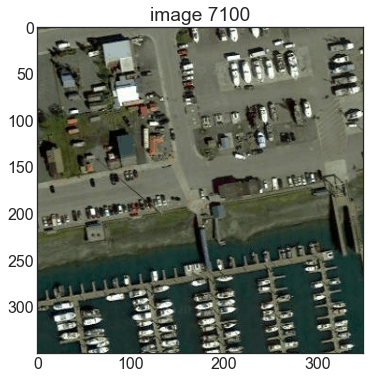

Pulling image 7170, total API requests so far = 859
satimg_AK_7170_Informal Campsite_17_60.11191899999999_-149.438404.png
waiting for: 5 seconds
Pulling image 7257, total API requests so far = 860
satimg_AK_7257_Informal Campsite_17_60.814011_-149.432994.png
waiting for: 5 seconds
Pulling image 7282, total API requests so far = 861
satimg_AK_7282_Informal Campsite_17_60.564211_-151.226595.png
waiting for: 1 seconds
Pulling image 7310, total API requests so far = 862
satimg_AK_7310_Informal Campsite_17_61.599886_-149.12696499999996.png
waiting for: 4 seconds
Pulling image 7376, total API requests so far = 863
satimg_AK_7376_Informal Campsite_17_65.062896_-146.143576.png
waiting for: 4 seconds
Pulling image 7440, total API requests so far = 864
satimg_AK_7440_Informal Campsite_17_64.040825_-145.736641.png
waiting for: 3 seconds
Pulling image 7590, total API requests so far = 865
satimg_AK_7590_Informal Campsite_17_61.182621_-149.933636.png
waiting for: 2 seconds
Pulling image 7595, total

Pulling image 12051, total API requests so far = 917
satimg_AK_12051_Showers_17_59.44994000000001_-135.31814.png
waiting for: 4 seconds
Pulling image 12153, total API requests so far = 918
satimg_AK_12153_Showers_17_62.32578_-150.23719.png
waiting for: 5 seconds
Water
AK
Pulling image 4708, total API requests so far = 919
satimg_AK_4708_Water_17_62.10728100000001_-145.516473.png
waiting for: 5 seconds
Pulling image 4729, total API requests so far = 920
satimg_AK_4729_Water_17_59.186220999999996_-135.40549199999998.png
waiting for: 3 seconds
Pulling image 4742, total API requests so far = 921
satimg_AK_4742_Water_17_61.778381_-149.197832.png
waiting for: 3 seconds
Pulling image 4783, total API requests so far = 922
satimg_AK_4783_Water_17_64.708224_-141.301616.png
waiting for: 2 seconds
Pulling image 5054, total API requests so far = 923
satimg_AK_5054_Water_17_60.48144_-151.097877.png
waiting for: 4 seconds
Pulling image 5127, total API requests so far = 924
satimg_AK_5127_Water_17_60.

Pulling image 6856, total API requests so far = 978
satimg_MT_6856_Wild Camping_17_48.010021_-114.301051.png
waiting for: 3 seconds
Pulling image 6926, total API requests so far = 979
satimg_MT_6926_Wild Camping_17_46.23227_-112.14039.png
waiting for: 4 seconds
Pulling image 6935, total API requests so far = 980
satimg_MT_6935_Wild Camping_17_47.158039_-113.52214.png
waiting for: 1 seconds
Pulling image 6977, total API requests so far = 981
satimg_MT_6977_Wild Camping_17_45.369423_-110.732129.png
waiting for: 3 seconds
Pulling image 7033, total API requests so far = 982
satimg_MT_7033_Wild Camping_17_47.01644_-114.508454.png
waiting for: 1 seconds
Pulling image 7129, total API requests so far = 983
satimg_MT_7129_Wild Camping_17_46.886386_-113.46233400000001.png
waiting for: 1 seconds
Pulling image 7130, total API requests so far = 984
satimg_MT_7130_Wild Camping_17_46.866925_-113.42313500000002.png
waiting for: 2 seconds
Pulling image 7138, total API requests so far = 985
satimg_MT_71

waiting for: 2 seconds
Pulling image 10639, total API requests so far = 1038
satimg_MT_10639_Wild Camping_17_48.309683_-113.970883.png
waiting for: 5 seconds
Pulling image 10644, total API requests so far = 1039
satimg_MT_10644_Wild Camping_17_48.414031_-115.54625300000001.png
waiting for: 1 seconds
Pulling image 10666, total API requests so far = 1040
satimg_MT_10666_Wild Camping_17_45.331239000000004_-113.243641.png
waiting for: 1 seconds
Pulling image 10671, total API requests so far = 1041
satimg_MT_10671_Wild Camping_17_48.457107_-114.034159.png
waiting for: 2 seconds
Pulling image 10704, total API requests so far = 1042
satimg_MT_10704_Wild Camping_17_46.07792_-114.25126599999999.png
waiting for: 1 seconds
Pulling image 10711, total API requests so far = 1043
satimg_MT_10711_Wild Camping_17_44.867398_-111.362303.png
waiting for: 5 seconds
Pulling image 10718, total API requests so far = 1044
satimg_MT_10718_Wild Camping_17_47.611297_-112.73678999999998.png
waiting for: 1 seconds


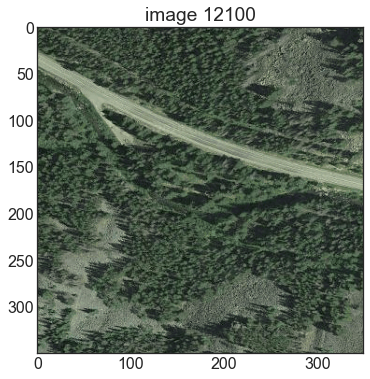

Pulling image 12103, total API requests so far = 1088
satimg_MT_12103_Wild Camping_17_46.169743_-113.907002.png
waiting for: 4 seconds
Pulling image 12110, total API requests so far = 1089
satimg_MT_12110_Wild Camping_17_45.81974500000001_-112.59177700000001.png
waiting for: 3 seconds
Pulling image 12111, total API requests so far = 1090
satimg_MT_12111_Wild Camping_17_45.823423999999996_-112.59141399999999.png
waiting for: 3 seconds
Pulling image 12138, total API requests so far = 1091
satimg_MT_12138_Wild Camping_17_45.258199_-109.68519199999999.png
waiting for: 4 seconds
Pulling image 12172, total API requests so far = 1092
satimg_MT_12172_Wild Camping_17_47.38427100000001_-113.556032.png
waiting for: 1 seconds
Informal Campsite
MT
Pulling image 3905, total API requests so far = 1093
satimg_MT_3905_Informal Campsite_17_44.603684_-113.039997.png
waiting for: 4 seconds
Pulling image 4074, total API requests so far = 1094
satimg_MT_4074_Informal Campsite_17_45.652867_-110.5985669999999

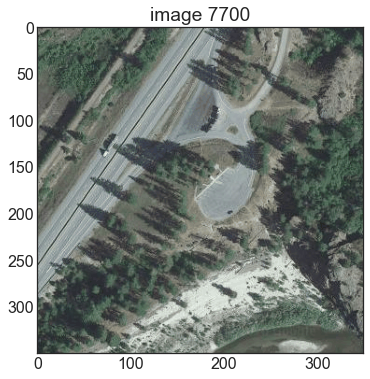

Pulling image 7760, total API requests so far = 1129
satimg_MT_7760_Informal Campsite_17_48.402213_-114.340271.png
waiting for: 2 seconds
Pulling image 7770, total API requests so far = 1130
satimg_MT_7770_Informal Campsite_17_46.909479_-114.03316000000001.png
waiting for: 4 seconds
Pulling image 7865, total API requests so far = 1131
satimg_MT_7865_Informal Campsite_17_46.990429999999996_-104.179859.png
waiting for: 5 seconds
Pulling image 8003, total API requests so far = 1132
satimg_MT_8003_Informal Campsite_17_45.98835800000001_-107.999283.png
waiting for: 4 seconds
Pulling image 8038, total API requests so far = 1133
satimg_MT_8038_Informal Campsite_17_47.492678999999995_-111.219222.png
waiting for: 3 seconds
Pulling image 8112, total API requests so far = 1134
satimg_MT_8112_Informal Campsite_17_46.59325_-111.99153000000001.png
waiting for: 3 seconds
Pulling image 8365, total API requests so far = 1135
satimg_MT_8365_Informal Campsite_17_46.411176_-112.72507399999999.png
waiting 

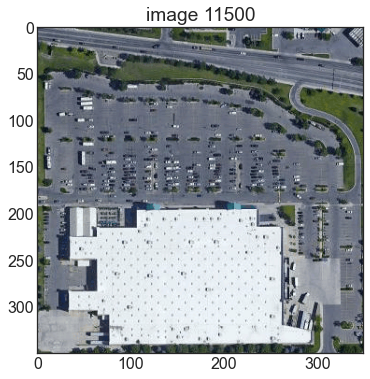

Pulling image 11501, total API requests so far = 1162
satimg_MT_11501_Informal Campsite_17_45.96262700000001_-112.508867.png
waiting for: 3 seconds
Pulling image 11785, total API requests so far = 1163
satimg_MT_11785_Informal Campsite_17_46.982907_-109.74465500000001.png
waiting for: 2 seconds
Pulling image 11866, total API requests so far = 1164
satimg_MT_11866_Informal Campsite_17_46.74944_-112.16972.png
waiting for: 4 seconds
Pulling image 11883, total API requests so far = 1165
satimg_MT_11883_Informal Campsite_17_45.059287_-109.41153700000001.png
waiting for: 4 seconds
Pulling image 11888, total API requests so far = 1166
satimg_MT_11888_Informal Campsite_17_45.453865_-113.122091.png
waiting for: 4 seconds
Pulling image 11981, total API requests so far = 1167
satimg_MT_11981_Informal Campsite_17_44.67467_-111.10011999999999.png
waiting for: 4 seconds
Pulling image 12029, total API requests so far = 1168
satimg_MT_12029_Informal Campsite_17_47.001445000000004_-113.371199.png
waiti

waiting for: 3 seconds
Pulling image 4522, total API requests so far = 1221
satimg_NM_4522_Wild Camping_17_36.284440000000004_-106.95083000000001.png
waiting for: 2 seconds
Pulling image 4523, total API requests so far = 1222
satimg_NM_4523_Wild Camping_17_36.25444_-107.66278.png
waiting for: 4 seconds
Pulling image 4524, total API requests so far = 1223
satimg_NM_4524_Wild Camping_17_36.26972_-108.25721999999999.png
waiting for: 2 seconds
Pulling image 4525, total API requests so far = 1224
satimg_NM_4525_Wild Camping_17_36.79528_-108.23472.png
waiting for: 2 seconds
Pulling image 4526, total API requests so far = 1225
satimg_NM_4526_Wild Camping_17_36.3375_-108.44693999999998.png
waiting for: 3 seconds
Pulling image 4612, total API requests so far = 1226
satimg_NM_4612_Wild Camping_17_34.0764_-107.45375.png
waiting for: 5 seconds
Pulling image 4723, total API requests so far = 1227
satimg_NM_4723_Wild Camping_17_35.207819_-106.41273000000001.png
waiting for: 5 seconds
Pulling image 4

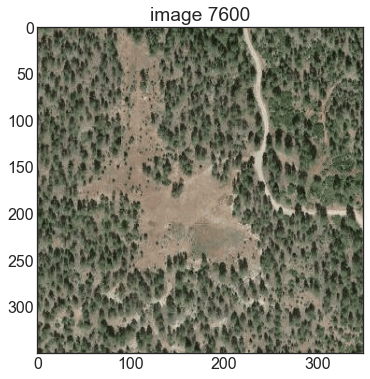

Pulling image 7615, total API requests so far = 1274
satimg_NM_7615_Wild Camping_17_35.779286_-105.571206.png
waiting for: 3 seconds
Pulling image 7616, total API requests so far = 1275
satimg_NM_7616_Wild Camping_17_35.671168_-105.72266699999999.png
waiting for: 3 seconds
Pulling image 7634, total API requests so far = 1276
satimg_NM_7634_Wild Camping_17_32.934108_-105.73381299999998.png
waiting for: 2 seconds
Pulling image 7742, total API requests so far = 1277
satimg_NM_7742_Wild Camping_17_36.525145_-106.477207.png
waiting for: 1 seconds
Pulling image 7993, total API requests so far = 1278
satimg_NM_7993_Wild Camping_17_36.307575_-105.73066200000001.png
waiting for: 4 seconds
Pulling image 8072, total API requests so far = 1279
satimg_NM_8072_Wild Camping_17_35.99672_-106.77051000000002.png
waiting for: 1 seconds
Pulling image 8158, total API requests so far = 1280
satimg_NM_8158_Wild Camping_17_32.841597_-105.52339199999999.png
waiting for: 1 seconds
Pulling image 8198, total API 

waiting for: 4 seconds
Pulling image 10172, total API requests so far = 1334
satimg_NM_10172_Wild Camping_17_35.4395_-108.54605.png
waiting for: 4 seconds
Pulling image 10195, total API requests so far = 1335
satimg_NM_10195_Wild Camping_17_34.232797999999995_-104.902828.png
waiting for: 5 seconds
Pulling image 10213, total API requests so far = 1336
satimg_NM_10213_Wild Camping_17_35.689853_-106.095552.png
waiting for: 4 seconds
Pulling image 10291, total API requests so far = 1337
satimg_NM_10291_Wild Camping_17_36.318543_-105.307257.png
waiting for: 2 seconds
Pulling image 10308, total API requests so far = 1338
satimg_NM_10308_Wild Camping_17_35.476842_-108.46703600000001.png
waiting for: 4 seconds
Pulling image 10491, total API requests so far = 1339
satimg_NM_10491_Wild Camping_17_36.545913_-105.229914.png
waiting for: 2 seconds
Pulling image 10563, total API requests so far = 1340
satimg_NM_10563_Wild Camping_17_35.637462_-106.01771200000002.png
waiting for: 2 seconds
Pulling im

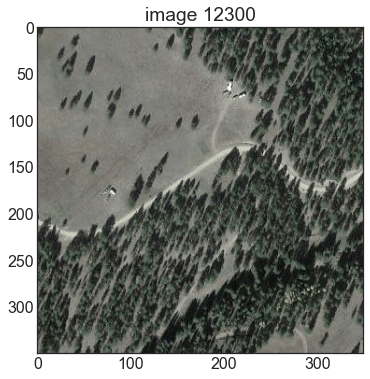

Pulling image 12362, total API requests so far = 1374
satimg_NM_12362_Wild Camping_17_32.20667_-104.33722.png
waiting for: 1 seconds
Pulling image 12372, total API requests so far = 1375
satimg_NM_12372_Wild Camping_17_32.29639_-104.32139000000001.png
waiting for: 5 seconds
Pulling image 12373, total API requests so far = 1376
satimg_NM_12373_Wild Camping_17_33.12_-108.18888999999999.png
waiting for: 4 seconds
Pulling image 12376, total API requests so far = 1377
satimg_NM_12376_Wild Camping_17_33.73111_-108.71943999999999.png
waiting for: 5 seconds
Pulling image 12377, total API requests so far = 1378
satimg_NM_12377_Wild Camping_17_34.04972_-106.86889.png
waiting for: 2 seconds
Pulling image 12378, total API requests so far = 1379
satimg_NM_12378_Wild Camping_17_35.04_-106.34388999999999.png
waiting for: 3 seconds
Informal Campsite
NM
Pulling image 3759, total API requests so far = 1380
satimg_NM_3759_Informal Campsite_17_35.14548_-103.799938.png
waiting for: 5 seconds
Pulling image 

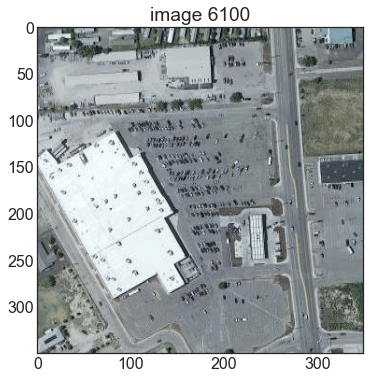

Pulling image 6118, total API requests so far = 1410
satimg_NM_6118_Informal Campsite_17_35.398161_-109.004131.png
waiting for: 5 seconds
Pulling image 6216, total API requests so far = 1411
satimg_NM_6216_Informal Campsite_17_34.94885_-104.64534.png
waiting for: 2 seconds
Pulling image 6314, total API requests so far = 1412
satimg_NM_6314_Informal Campsite_17_32.39301_-104.222262.png
waiting for: 5 seconds
Pulling image 6330, total API requests so far = 1413
satimg_NM_6330_Informal Campsite_17_34.934788_-106.662846.png
waiting for: 2 seconds
Pulling image 6334, total API requests so far = 1414
satimg_NM_6334_Informal Campsite_17_33.449106_-104.525306.png
waiting for: 5 seconds
Pulling image 6360, total API requests so far = 1415
satimg_NM_6360_Informal Campsite_17_34.944720000000004_-104.640875.png
waiting for: 2 seconds
Pulling image 6413, total API requests so far = 1416
satimg_NM_6413_Informal Campsite_17_34.981970000000004_-105.08198999999999.png
waiting for: 2 seconds
Pulling ima

waiting for: 1 seconds
Pulling image 12358, total API requests so far = 1468
satimg_NM_12358_Informal Campsite_17_32.104676_-104.424348.png
waiting for: 3 seconds
Pulling image 12359, total API requests so far = 1469
satimg_NM_12359_Informal Campsite_17_35.20432_-106.65658.png
waiting for: 5 seconds
Showers
NM
Pulling image 5677, total API requests so far = 1470
satimg_NM_5677_Showers_17_32.90178_-105.94426000000001.png
waiting for: 3 seconds
Pulling image 5715, total API requests so far = 1471
satimg_NM_5715_Showers_17_32.316802_-106.76644399999999.png
waiting for: 1 seconds
Pulling image 6353, total API requests so far = 1472
satimg_NM_6353_Showers_17_35.883493_-106.30046000000002.png
waiting for: 1 seconds
Pulling image 6561, total API requests so far = 1473
satimg_NM_6561_Showers_17_32.58795_-107.97431.png
waiting for: 1 seconds
Pulling image 9648, total API requests so far = 1474
satimg_NM_9648_Showers_17_36.377221999999996_-105.576704.png
waiting for: 1 seconds
Water
NM
Pulling i

Pulling image 5456, total API requests so far = 1528
satimg_ID_5456_Wild Camping_17_43.740718_-114.355791.png
waiting for: 1 seconds
Pulling image 5504, total API requests so far = 1529
satimg_ID_5504_Wild Camping_17_44.166658_-114.89601499999999.png
waiting for: 5 seconds
Pulling image 5505, total API requests so far = 1530
satimg_ID_5505_Wild Camping_17_44.256325_-115.045303.png
waiting for: 2 seconds
Pulling image 5506, total API requests so far = 1531
satimg_ID_5506_Wild Camping_17_44.256325_-115.045303.png
waiting for: 3 seconds
Pulling image 5516, total API requests so far = 1532
satimg_ID_5516_Wild Camping_17_47.604533_-116.65356100000001.png
waiting for: 3 seconds
Pulling image 5766, total API requests so far = 1533
satimg_ID_5766_Wild Camping_17_44.11306_-111.06667.png
waiting for: 1 seconds
Pulling image 5767, total API requests so far = 1534
satimg_ID_5767_Wild Camping_17_44.30556_-111.43278000000001.png
waiting for: 2 seconds
Pulling image 5768, total API requests so far = 

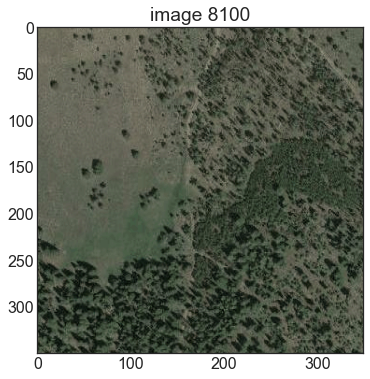

Pulling image 8102, total API requests so far = 1575
satimg_ID_8102_Wild Camping_17_44.20988300000001_-114.982872.png
waiting for: 3 seconds
Pulling image 8185, total API requests so far = 1576
satimg_ID_8185_Wild Camping_17_42.323934_-113.045758.png
waiting for: 2 seconds
Pulling image 8186, total API requests so far = 1577
satimg_ID_8186_Wild Camping_17_42.335229_-113.04446100000001.png
waiting for: 5 seconds
Pulling image 8443, total API requests so far = 1578
satimg_ID_8443_Wild Camping_17_44.64833_-116.30542.png
waiting for: 2 seconds
Pulling image 8444, total API requests so far = 1579
satimg_ID_8444_Wild Camping_17_44.74361_-116.16083.png
waiting for: 4 seconds
Pulling image 8446, total API requests so far = 1580
satimg_ID_8446_Wild Camping_17_44.67403_-115.68833000000001.png
waiting for: 3 seconds
Pulling image 8447, total API requests so far = 1581
satimg_ID_8447_Wild Camping_17_44.57167000000001_-116.14806000000002.png
waiting for: 5 seconds
Pulling image 8451, total API requ

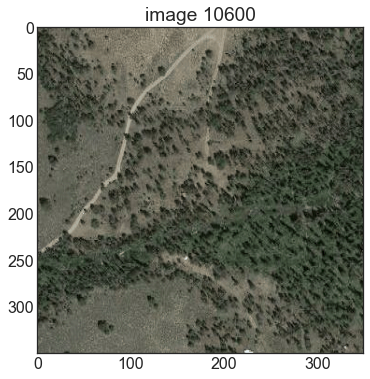

Pulling image 10640, total API requests so far = 1626
satimg_ID_10640_Wild Camping_17_43.493536999999996_-113.545005.png
waiting for: 2 seconds
Pulling image 10645, total API requests so far = 1627
satimg_ID_10645_Wild Camping_17_43.737272_-114.300719.png
waiting for: 3 seconds
Pulling image 10651, total API requests so far = 1628
satimg_ID_10651_Wild Camping_17_44.416142_-112.156922.png
waiting for: 4 seconds
Pulling image 10713, total API requests so far = 1629
satimg_ID_10713_Wild Camping_17_43.07976_-115.50498999999999.png
waiting for: 4 seconds
Pulling image 10722, total API requests so far = 1630
satimg_ID_10722_Wild Camping_17_44.028533_-114.839276.png
waiting for: 5 seconds
Pulling image 10789, total API requests so far = 1631
satimg_ID_10789_Wild Camping_17_47.376189000000004_-115.76304499999999.png
waiting for: 4 seconds
Pulling image 10800, total API requests so far = 1632
satimg_ID_10800_Wild Camping_17_43.950520000000004_-114.83231.png
waiting for: 5 seconds


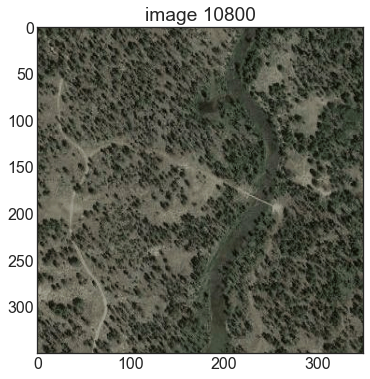

Pulling image 10802, total API requests so far = 1633
satimg_ID_10802_Wild Camping_17_46.5875_-114.556339.png
waiting for: 5 seconds
Pulling image 10850, total API requests so far = 1634
satimg_ID_10850_Wild Camping_17_43.444635_-111.382304.png
waiting for: 3 seconds
Pulling image 10911, total API requests so far = 1635
satimg_ID_10911_Wild Camping_17_42.185458000000004_-113.93996299999999.png
waiting for: 5 seconds
Pulling image 10932, total API requests so far = 1636
satimg_ID_10932_Wild Camping_17_48.458096999999995_-116.89218600000001.png
waiting for: 4 seconds
Pulling image 10944, total API requests so far = 1637
satimg_ID_10944_Wild Camping_17_44.636835999999995_-115.71648400000001.png
waiting for: 4 seconds
Pulling image 10950, total API requests so far = 1638
satimg_ID_10950_Wild Camping_17_44.040879_-114.834115.png
waiting for: 3 seconds
Pulling image 10951, total API requests so far = 1639
satimg_ID_10951_Wild Camping_17_43.926014_-114.762225.png
waiting for: 4 seconds
Pullin

waiting for: 3 seconds
Pulling image 6959, total API requests so far = 1691
satimg_ID_6959_Informal Campsite_17_48.264581_-116.562351.png
waiting for: 3 seconds
Pulling image 6988, total API requests so far = 1692
satimg_ID_6988_Informal Campsite_17_43.384713_-115.99798500000001.png
waiting for: 4 seconds
Pulling image 7015, total API requests so far = 1693
satimg_ID_7015_Informal Campsite_17_43.244495_-113.99583600000001.png
waiting for: 1 seconds
Pulling image 7027, total API requests so far = 1694
satimg_ID_7027_Informal Campsite_17_42.93705300000001_-115.07268899999998.png
waiting for: 5 seconds
Pulling image 7085, total API requests so far = 1695
satimg_ID_7085_Informal Campsite_17_42.649914_-114.444892.png
waiting for: 2 seconds
Pulling image 7271, total API requests so far = 1696
satimg_ID_7271_Informal Campsite_17_43.548522_-113.008905.png
waiting for: 2 seconds
Pulling image 7319, total API requests so far = 1697
satimg_ID_7319_Informal Campsite_17_43.915171_-113.610359.png
wa

waiting for: 3 seconds
Pulling image 7231, total API requests so far = 1749
satimg_ID_7231_Water_17_43.907714_-114.796104.png
waiting for: 3 seconds
Pulling image 7244, total API requests so far = 1750
satimg_ID_7244_Water_17_44.144281_-114.918102.png
waiting for: 3 seconds
Pulling image 8450, total API requests so far = 1751
satimg_ID_8450_Water_17_43.496424_-112.06362.png
waiting for: 1 seconds
Pulling image 10044, total API requests so far = 1752
satimg_ID_10044_Water_17_44.628122999999995_-111.33315.png
waiting for: 4 seconds
Pulling image 10192, total API requests so far = 1753
satimg_ID_10192_Water_17_43.630872_-113.293125.png
waiting for: 1 seconds
Pulling image 10281, total API requests so far = 1754
satimg_ID_10281_Water_17_42.66128_-112.20436000000001.png
waiting for: 5 seconds
Pulling image 10371, total API requests so far = 1755
satimg_ID_10371_Water_17_44.669140999999996_-111.288551.png
waiting for: 5 seconds
Pulling image 10624, total API requests so far = 1756
satimg_ID_

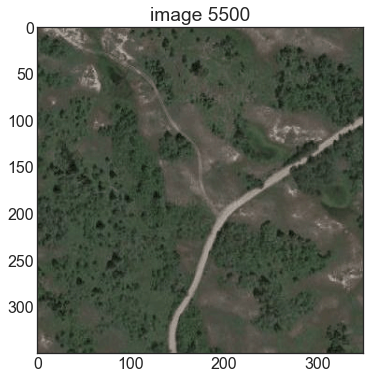

Pulling image 5757, total API requests so far = 1783
satimg_WY_5757_Wild Camping_17_41.04667_-105.74528000000001.png
waiting for: 4 seconds
Pulling image 5759, total API requests so far = 1784
satimg_WY_5759_Wild Camping_17_42.735279999999996_-105.62111000000002.png
waiting for: 5 seconds
Pulling image 5762, total API requests so far = 1785
satimg_WY_5762_Wild Camping_17_44.64139_-104.37611.png
waiting for: 2 seconds
Pulling image 5764, total API requests so far = 1786
satimg_WY_5764_Wild Camping_17_43.5875_-110.35972.png
waiting for: 1 seconds
Pulling image 5765, total API requests so far = 1787
satimg_WY_5765_Wild Camping_17_43.64083_-110.58111000000001.png
waiting for: 5 seconds
Pulling image 5918, total API requests so far = 1788
satimg_WY_5918_Wild Camping_17_41.47603_-106.800145.png
waiting for: 2 seconds
Pulling image 6109, total API requests so far = 1789
satimg_WY_6109_Wild Camping_17_43.767765999999995_-110.54170900000001.png
waiting for: 2 seconds
Pulling image 6309, total A

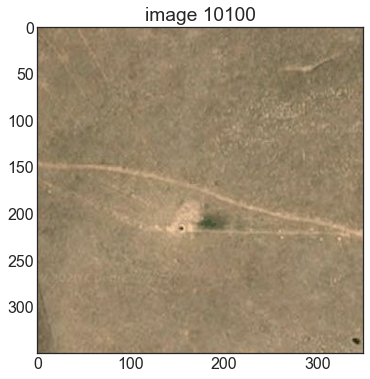

Pulling image 10103, total API requests so far = 1834
satimg_WY_10103_Wild Camping_17_44.457729_-104.43639499999999.png
waiting for: 2 seconds
Pulling image 10185, total API requests so far = 1835
satimg_WY_10185_Wild Camping_17_43.718117_-109.983942.png
waiting for: 3 seconds
Pulling image 10194, total API requests so far = 1836
satimg_WY_10194_Wild Camping_17_44.477638_-104.44951400000001.png
waiting for: 4 seconds
Pulling image 10210, total API requests so far = 1837
satimg_WY_10210_Wild Camping_17_43.472811_-110.76253500000001.png
waiting for: 4 seconds
Pulling image 10266, total API requests so far = 1838
satimg_WY_10266_Wild Camping_17_43.380632_-108.08588400000001.png
waiting for: 4 seconds
Pulling image 10277, total API requests so far = 1839
satimg_WY_10277_Wild Camping_17_42.25232800000001_-109.42993600000001.png
waiting for: 2 seconds
Pulling image 10293, total API requests so far = 1840
satimg_WY_10293_Wild Camping_17_43.611312_-110.44037800000001.png
waiting for: 4 seconds

waiting for: 5 seconds
Pulling image 11563, total API requests so far = 1893
satimg_WY_11563_Wild Camping_17_43.733290000000004_-110.58639.png
waiting for: 1 seconds
Pulling image 11678, total API requests so far = 1894
satimg_WY_11678_Wild Camping_17_43.844048_-110.405151.png
waiting for: 2 seconds
Pulling image 11868, total API requests so far = 1895
satimg_WY_11868_Wild Camping_17_44.89944000000001_-108.63944.png
waiting for: 1 seconds
Pulling image 11887, total API requests so far = 1896
satimg_WY_11887_Wild Camping_17_43.629838_-110.546287.png
waiting for: 3 seconds
Pulling image 11899, total API requests so far = 1897
satimg_WY_11899_Wild Camping_17_42.614461999999996_-110.861346.png
waiting for: 1 seconds
Pulling image 11900, total API requests so far = 1898
satimg_WY_11900_Wild Camping_17_44.955407_-109.812823.png
waiting for: 1 seconds


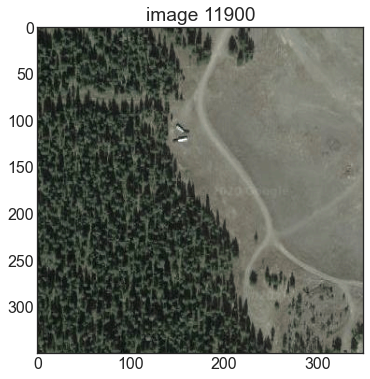

Pulling image 11944, total API requests so far = 1899
satimg_WY_11944_Wild Camping_17_41.235359_-109.59429399999999.png
waiting for: 1 seconds
Pulling image 12019, total API requests so far = 1900
satimg_WY_12019_Wild Camping_17_43.71112_-110.585816.png
waiting for: 4 seconds
Pulling image 12043, total API requests so far = 1901
satimg_WY_12043_Wild Camping_17_44.249357_-106.941313.png
waiting for: 3 seconds
Pulling image 12079, total API requests so far = 1902
satimg_WY_12079_Wild Camping_17_41.15287100000001_-105.37288799999999.png
waiting for: 3 seconds
Pulling image 12171, total API requests so far = 1903
satimg_WY_12171_Wild Camping_17_44.795596_-109.429549.png
waiting for: 1 seconds
Pulling image 12192, total API requests so far = 1904
satimg_WY_12192_Wild Camping_17_41.009048_-109.54643200000001.png
waiting for: 5 seconds
Pulling image 12218, total API requests so far = 1905
satimg_WY_12218_Wild Camping_17_43.14348_-110.977484.png
waiting for: 1 seconds
Pulling image 12304, tota

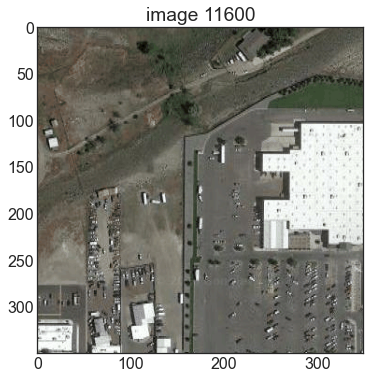

Pulling image 12028, total API requests so far = 1938
satimg_WY_12028_Informal Campsite_17_44.16424_-107.14435800000001.png
waiting for: 2 seconds
Pulling image 12129, total API requests so far = 1939
satimg_WY_12129_Informal Campsite_17_43.38878_-108.15328999999998.png
waiting for: 2 seconds
Pulling image 12130, total API requests so far = 1940
satimg_WY_12130_Informal Campsite_17_42.981789_-108.394729.png
waiting for: 3 seconds
Pulling image 12135, total API requests so far = 1941
satimg_WY_12135_Informal Campsite_17_41.79378300000001_-107.22761399999999.png
waiting for: 3 seconds
Pulling image 12189, total API requests so far = 1942
satimg_WY_12189_Informal Campsite_17_44.958395_-109.81069099999999.png
waiting for: 5 seconds
Pulling image 12223, total API requests so far = 1943
satimg_WY_12223_Informal Campsite_17_42.849253000000004_-106.265952.png
waiting for: 4 seconds
Pulling image 12306, total API requests so far = 1944
satimg_WY_12306_Informal Campsite_17_42.24558_-109.43358.pn

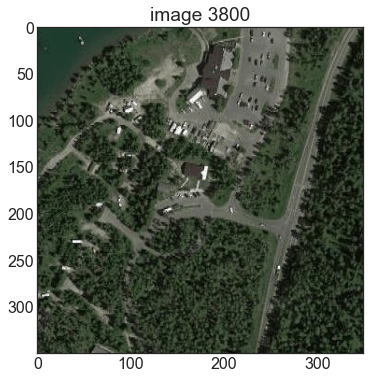

Pulling image 4981, total API requests so far = 1946
satimg_WY_4981_Showers_17_44.459994_-110.83146699999999.png
waiting for: 3 seconds
Pulling image 5263, total API requests so far = 1947
satimg_WY_5263_Showers_17_43.904579999999996_-110.641548.png
waiting for: 5 seconds
Pulling image 5437, total API requests so far = 1948
satimg_WY_5437_Showers_17_44.521639_-109.058341.png
waiting for: 5 seconds
Pulling image 6654, total API requests so far = 1949
satimg_WY_6654_Showers_17_43.481913_-110.75947099999999.png
waiting for: 1 seconds
Pulling image 6687, total API requests so far = 1950
satimg_WY_6687_Showers_17_44.977768_-110.703112.png
waiting for: 1 seconds
Pulling image 6888, total API requests so far = 1951
satimg_WY_6888_Showers_17_44.73545900000001_-110.487835.png
waiting for: 3 seconds
Pulling image 10324, total API requests so far = 1952
satimg_WY_10324_Showers_17_41.30988_-105.616234.png
waiting for: 1 seconds
Water
WY
Pulling image 4716, total API requests so far = 1953
satimg_W

waiting for: 3 seconds
Pulling image 6709, total API requests so far = 2007
satimg_NV_6709_Wild Camping_17_36.162397_-115.14815700000001.png
waiting for: 2 seconds
Pulling image 6734, total API requests so far = 2008
satimg_NV_6734_Wild Camping_17_37.440245000000004_-115.37850300000001.png
waiting for: 5 seconds
Pulling image 6741, total API requests so far = 2009
satimg_NV_6741_Wild Camping_17_38.829913_-119.696549.png
waiting for: 2 seconds
Pulling image 6916, total API requests so far = 2010
satimg_NV_6916_Wild Camping_17_39.280638_-114.947377.png
waiting for: 5 seconds
Pulling image 6947, total API requests so far = 2011
satimg_NV_6947_Wild Camping_17_41.541265_-117.772122.png
waiting for: 4 seconds
Pulling image 6987, total API requests so far = 2012
satimg_NV_6987_Wild Camping_17_38.403347_-114.629466.png
waiting for: 2 seconds
Pulling image 7000, total API requests so far = 2013
satimg_NV_7000_Wild Camping_17_39.330321999999995_-119.87088.png
waiting for: 1 seconds


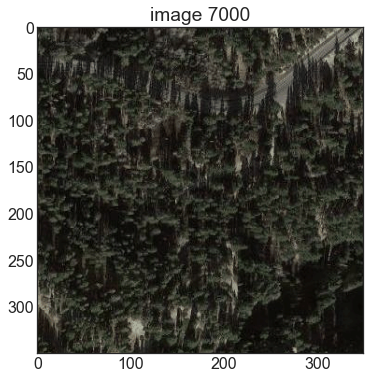

Pulling image 7007, total API requests so far = 2014
satimg_NV_7007_Wild Camping_17_37.90671_-114.41758600000001.png
waiting for: 4 seconds
Pulling image 7008, total API requests so far = 2015
satimg_NV_7008_Wild Camping_17_37.621928000000004_-114.563769.png
waiting for: 3 seconds
Pulling image 7050, total API requests so far = 2016
satimg_NV_7050_Wild Camping_17_41.238812_-114.95748400000001.png
waiting for: 2 seconds
Pulling image 7087, total API requests so far = 2017
satimg_NV_7087_Wild Camping_17_39.281832_-119.741064.png
waiting for: 3 seconds
Pulling image 7516, total API requests so far = 2018
satimg_NV_7516_Wild Camping_17_39.130435999999996_-119.80658799999999.png
waiting for: 2 seconds
Pulling image 7596, total API requests so far = 2019
satimg_NV_7596_Wild Camping_17_36.757427_-114.236971.png
waiting for: 3 seconds
Pulling image 7766, total API requests so far = 2020
satimg_NV_7766_Wild Camping_17_39.818042999999996_-116.16855.png
waiting for: 5 seconds
Pulling image 7778, 

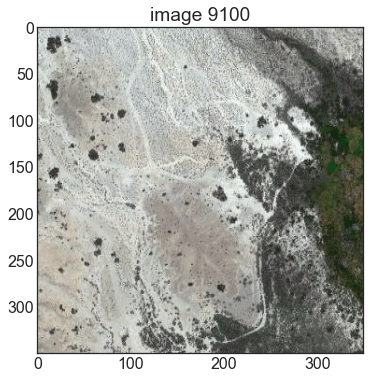

Pulling image 9101, total API requests so far = 2046
satimg_NV_9101_Wild Camping_17_36.369946999999996_-116.075718.png
waiting for: 4 seconds
Pulling image 9112, total API requests so far = 2047
satimg_NV_9112_Wild Camping_17_36.282323_-116.135218.png
waiting for: 2 seconds
Pulling image 9173, total API requests so far = 2048
satimg_NV_9173_Wild Camping_17_36.098617_-115.339001.png
waiting for: 1 seconds
Pulling image 9212, total API requests so far = 2049
satimg_NV_9212_Wild Camping_17_39.382976_-119.798077.png
waiting for: 1 seconds
Pulling image 9214, total API requests so far = 2050
satimg_NV_9214_Wild Camping_17_38.874433_-119.69000600000001.png
waiting for: 5 seconds
Pulling image 9426, total API requests so far = 2051
satimg_NV_9426_Wild Camping_17_35.881396_-114.93588600000001.png
waiting for: 2 seconds
Pulling image 9502, total API requests so far = 2052
satimg_NV_9502_Wild Camping_17_36.134523_-115.56966299999999.png
waiting for: 4 seconds
Pulling image 9676, total API reques

waiting for: 3 seconds
Pulling image 4545, total API requests so far = 2105
satimg_NV_4545_Informal Campsite_17_36.342698_-115.64538300000001.png
waiting for: 2 seconds
Pulling image 4568, total API requests so far = 2106
satimg_NV_4568_Informal Campsite_17_36.775063_-114.28334299999999.png
waiting for: 3 seconds
Pulling image 4701, total API requests so far = 2107
satimg_NV_4701_Informal Campsite_17_39.53331_-119.76396000000001.png
waiting for: 1 seconds
Pulling image 4728, total API requests so far = 2108
satimg_NV_4728_Informal Campsite_17_35.78171500000001_-115.33283999999999.png
waiting for: 1 seconds
Pulling image 4737, total API requests so far = 2109
satimg_NV_4737_Informal Campsite_17_39.61049000000001_-119.21578999999998.png
waiting for: 2 seconds
Pulling image 4979, total API requests so far = 2110
satimg_NV_4979_Informal Campsite_17_39.187253999999996_-119.75766599999999.png
waiting for: 5 seconds
Pulling image 5315, total API requests so far = 2111
satimg_NV_5315_Informal 

waiting for: 4 seconds
Pulling image 12407, total API requests so far = 2162
satimg_NV_12407_Informal Campsite_17_36.777770000000004_-114.266143.png
waiting for: 1 seconds
Showers
NV
Pulling image 4503, total API requests so far = 2163
satimg_NV_4503_Showers_17_39.008759999999995_-114.12205.png
waiting for: 4 seconds
Pulling image 5314, total API requests so far = 2164
satimg_NV_5314_Showers_17_39.169067999999996_-119.75998100000001.png
waiting for: 5 seconds
Pulling image 5606, total API requests so far = 2165
satimg_NV_5606_Showers_17_36.218636_-115.125847.png
waiting for: 3 seconds
Pulling image 8293, total API requests so far = 2166
satimg_NV_8293_Showers_17_37.821845_-114.415819.png
waiting for: 5 seconds
Pulling image 8317, total API requests so far = 2167
satimg_NV_8317_Showers_17_36.173065_-115.332641.png
waiting for: 1 seconds
Pulling image 8518, total API requests so far = 2168
satimg_NV_8518_Showers_17_36.060633_-115.29953.png
waiting for: 4 seconds
Pulling image 8781, total

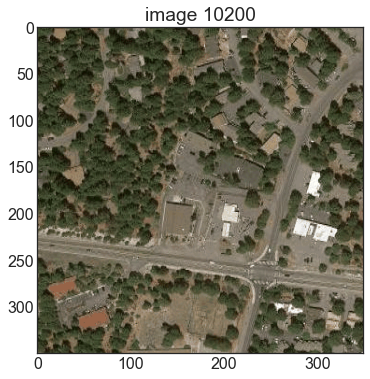

Short-term Parking
NV
Pulling image 8565, total API requests so far = 2184
satimg_NV_8565_Short-term Parking_17_36.08781_-115.131875.png
waiting for: 2 seconds
Pulling image 12363, total API requests so far = 2185
satimg_NV_12363_Short-term Parking_17_36.12828_-115.17074.png
waiting for: 4 seconds
Eco-Friendly
NV
Wild Camping
NY
Pulling image 4189, total API requests so far = 2186
satimg_NY_4189_Wild Camping_17_40.774011_-73.964637.png
waiting for: 3 seconds
Pulling image 4190, total API requests so far = 2187
satimg_NY_4190_Wild Camping_17_40.781907000000004_-73.414528.png
waiting for: 3 seconds
Pulling image 4290, total API requests so far = 2188
satimg_NY_4290_Wild Camping_17_42.766956_-78.12694499999998.png
waiting for: 4 seconds
Pulling image 4608, total API requests so far = 2189
satimg_NY_4608_Wild Camping_17_42.53188400000001_-76.615871.png
waiting for: 4 seconds
Pulling image 4642, total API requests so far = 2190
satimg_NY_4642_Wild Camping_17_43.313478_-74.650352.png
waiting

waiting for: 4 seconds
Pulling image 4401, total API requests so far = 2244
satimg_NY_4401_Informal Campsite_17_43.390728_-74.72106.png
waiting for: 4 seconds
Pulling image 4402, total API requests so far = 2245
satimg_NY_4402_Informal Campsite_17_43.17657_-76.095294.png
waiting for: 2 seconds
Pulling image 4583, total API requests so far = 2246
satimg_NY_4583_Informal Campsite_17_43.187862_-76.24316800000003.png
waiting for: 3 seconds
Pulling image 4598, total API requests so far = 2247
satimg_NY_4598_Informal Campsite_17_41.317685_-74.152243.png
waiting for: 3 seconds
Pulling image 4611, total API requests so far = 2248
satimg_NY_4611_Informal Campsite_17_42.454152_-76.806545.png
waiting for: 5 seconds
Pulling image 4624, total API requests so far = 2249
satimg_NY_4624_Informal Campsite_17_42.87993_-75.72284.png
waiting for: 5 seconds
Pulling image 4684, total API requests so far = 2250
satimg_NY_4684_Informal Campsite_17_43.095221_-78.977009.png
waiting for: 5 seconds
Pulling image 

In [31]:
for name, state in zip(names, state_dfs):
    for category in categories:
        print(category)
        tempdf = state[state['Category'] == category]
        #tempdf.info()
        print(name)
        download_images(gmaps, tempdf, max_requests=max_requests, zoomlevel=17, prefix=f'{name}', out_path=f"../data/sat_images/sites_{name}/{category}/")